In [5]:
import torch
import numpy as np
from easy_transformer import EasyTransformer, EasyTransformerConfig
import easy_transformer
import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
vocab_size = 500
sequence_length = 10
batch_size = 64

tiny_cfg = EasyTransformerConfig(
    d_model=32,
    d_head=8,
    n_heads=4,
    d_mlp=32,
    n_layers=2,
    n_ctx=100,
    act_fn="solu_ln",
    d_vocab=vocab_size,
    normalization_type="LN",
    seed=0,
)
tiny_model = EasyTransformer(tiny_cfg).to(device)
cross_entropy_loss = torch.nn.CrossEntropyLoss()

Moving model to device:  cuda
Moving model to device:  cuda


In [7]:
start_token = 0
sep_token = 1
ignore_token = 2
num_special_tokens = 3
def get_copy_instance(batch_size,seq_size, vocab_size):
  seqs = torch.randint(num_special_tokens, vocab_size, (batch_size, seq_size)).to(device)

  input1 = torch.cat([
      torch.ones((batch_size,1),device=device)*sep_token,
      seqs,
  ],dim=1)

  input2 = torch.cat([
      torch.ones((batch_size,1),device=device)*sep_token,
      seqs,
  ],dim=1)[:,:-1]

  output1 = torch.cat([
      torch.ones((batch_size,1+seq_size),device=device)*ignore_token,
  ],dim=1)
  output2 = torch.cat([
      seqs,
      torch.ones((batch_size,1),device=device)*sep_token,
  ],dim=1)[:,:-1]

  perm = torch.randperm(seq_size,device=device)
  input = torch.cat([input1,input2[:,perm]],dim=1)
  output = torch.cat([output1,output2[:,perm]],dim=1)

  return input.long(),output.long()

In [8]:
eval_inputs, eval_outputs = get_copy_instance(1000, 20, tiny_model.cfg.d_vocab)

In [9]:
def get_loss(model, inputs, outputs):
    inputs = inputs.to(device)
    outputs = outputs.to(device)
    
    output_logits = model(inputs, return_type="logits")

    seq_len = inputs.shape[1]

    loss = cross_entropy_loss(
        output_logits[:,seq_len//2+1:].reshape((-1,vocab_size)),
        outputs[:,seq_len//2+1:].reshape((-1,)))
    
    return loss

def evaluate_model(model, batch_size, print_output, number_to_print=0):
    vocab_size = model.cfg.d_vocab
    inputs,outputs = get_copy_instance(batch_size,random.randint(5,30),vocab_size)

    loss = get_loss(model,inputs,outputs)

    if print_output:
      eval_loss = get_loss(model,eval_inputs, eval_outputs)
      print(eval_loss.item())

    return loss

In [10]:
loss_history = []
print('before training')
loss = evaluate_model(tiny_model, batch_size=3000, print_output=True)
for epoch in tqdm.tqdm(range(100001)):
    loss = evaluate_model(tiny_model, batch_size=batch_size, print_output=epoch % 100 == 0, number_to_print=0)
    loss.backward()
    loss_history.append(loss.item())
    tiny_optimizer.step()
    tiny_optimizer.zero_grad()

before training
6.514003753662109


  0%|          | 4/100001 [00:00<51:21, 32.45it/s]

6.514003753662109


  0%|          | 331/100001 [00:08<41:21, 40.17it/s]


KeyboardInterrupt: 

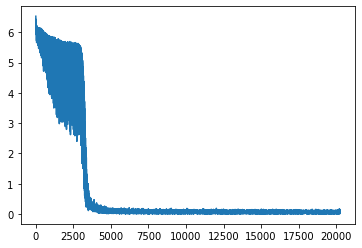

In [62]:
plt.plot(loss_history)

In [74]:
import pysvelte
def show_attention_pattern_for_input(model, input,output):
    model_cache={}
    model.cache_all(model_cache) # remove_batch_dim=True
    model(input)
    model.reset_hooks()
    tokens = [str(x) for x in input[0].tolist()]
    print('tokens', tokens, 'len(tokens)', len(tokens))
    pysvelte.AttentionMulti(tokens=tokens, attention=model_cache['blocks.0.attn.hook_attn'][0].permute(1, 2, 0)).show()


In [75]:
inputs,outputs = get_copy_instance(3,10,100)

output_logits = tiny_model(inputs, return_type="logits")
predictions = output_logits.argmax(dim=2)

In [ ]:
print(np.array([
    inputs[0].tolist(),
    outputs[0].tolist(),
    predictions[0].tolist()
  ]))

show_attention_pattern_for_input(tiny_model,inputs,outputs)

[[ 1 67 48 79 44 58 73 68 19 35 17 58  1 68 19 48 44 35 73 67 79]
 [ 2  2  2  2  2  2  2  2  2  2  2 73 67 19 35 79 58 17 68 48 44]
 [ 2  2  2  2  2  2  2  2  2  2  2 73 67 19 35 79 58 17 68 48 44]]
tokens ['1', '67', '48', '79', '44', '58', '73', '68', '19', '35', '17', '58', '1', '68', '19', '48', '44', '35', '73', '67', '79'] len(tokens) 21
pysvelte components appear to be unbuilt or stale
Running npm install...


In [72]:
tiny_model(torch.tensor([[1,3,4,5,6,7,5,6,6]]), return_type="logits").argmax(dim=2)

tensor([[  2,   2,   2,   2,   2,   2,   6,   7, 363]], device='cuda:0')